In [135]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

In [136]:
df = pd.read_csv("bilan-electrique-jour.csv", sep=";")
df['Jour'] = df['Jour'].apply(pd.to_datetime)
df = df[['Puissance moyenne journalière des consommations totales (W)', 'Température moyenne journalière réalisée lissée (°C)']]
df = df.rename(columns={'Puissance moyenne journalière des consommations totales (W)': 'Consommation', 'Température moyenne journalière réalisée lissée (°C)': 'Temp'})
df.head()

,Consommation,Temp
0,4.633333e+10,8.3
1,4.610963e+10,8.9
2,4.534297e+10,9.5
3,4.144277e+10,11.6
4,4.031210e+10,10.4


In [137]:
# Divisez les données en train et test
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [138]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Consommation,1461.0,3.933109e+10,8.946114e+09,2.499842e+10,3.289994e+10,3.633759e+10,4.624269e+10,6.634287e+10
Temp,1461.0,1.340390e+01,6.265805e+00,-4.000000e-01,8.500000e+00,1.270000e+01,1.900000e+01,2.860000e+01


In [139]:
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Consommation,365.0,3.912242e+10,9.002863e+09,2.573493e+10,3.278430e+10,3.563496e+10,4.574976e+10,6.922182e+10
Temp,365.0,1.353370e+01,6.279816e+00,-1.800000e+00,8.300000e+00,1.330000e+01,1.920000e+01,2.750000e+01


In [157]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Le modèle doit prédire la consomation à partir de la température
train_labels = np.log(train_features.pop('Consommation'))
test_labels = np.log(test_features.pop('Consommation'))

# feature = caractéristique entrée
print(train_features["Temp"])

# label = valeur cible
print(train_labels)

793      8.7
789      6.8
118     11.3
318      8.3
891     11.8
        ... 
732     14.4
715     11.0
832      8.8
951     11.1
1144    17.5
Name: Temp, Length: 1461, dtype: float64
793     24.598620
789     24.664658
118     24.490491
318     24.500869
891     24.440160
          ...    
732     24.316119
715     24.403948
832     24.597543
951     24.389179
1144    24.015062
Name: Consommation, Length: 1461, dtype: float64


In [158]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[13.4039]


In [159]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[8.7]]

Normalized: [[-0.75]]


In [160]:
temp = np.array(train_features['Temp'])
print(temp)
temp_normalizer = preprocessing.Normalization()
temp_normalizer.adapt(temp)


[ 8.7  6.8 11.3 ...  8.8 11.1 17.5]


In [161]:
temp_model = tf.keras.Sequential([
    temp_normalizer,
    layers.Dense(units=1)
])

temp_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_18 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [162]:
# Predicting without training
temp_model.predict(temp[:10])

array([[ 0.98466474],
       [ 1.3823905 ],
       [ 0.44040817],
       [ 1.0683963 ],
       [ 0.33574343],
       [ 0.859067  ],
       [-1.1923614 ],
       [-0.8574342 ],
       [-1.7994167 ],
       [-0.5853061 ]], dtype=float32)

In [163]:
# Procédure d'entraînement
temp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error') # on optimise la mean_absolute_error

In [173]:
%%time
history = temp_model.fit(
    train_features['Temp'], train_labels,
    epochs=1000,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.6)

ep - loss: 0.0873 - val_loss: 0.0895
Epoch 806/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.0873 - val_loss: 0.0894
Epoch 807/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0893
Epoch 808/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.0872 - val_loss: 0.0894
Epoch 809/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.0894
Epoch 810/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0893
Epoch 811/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.0893
Epoch 812/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0893
Epoch 813/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0893
Epoch 814/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.0893
Epoch 815/1000
19/19 [=======================

In [167]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,0.087250,0.089330,995
996,0.087261,0.089365,996
997,0.087221,0.089295,997
998,0.087289,0.089302,998
999,0.087269,0.089377,999


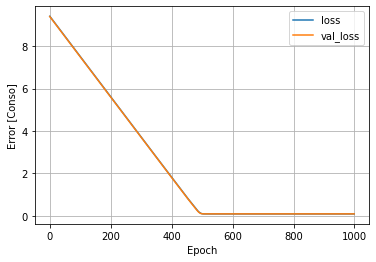

In [168]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Conso]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [169]:
test_results = {}

test_results['temp_model'] = temp_model.evaluate(
    test_features['Temp'],
    test_labels, verbose=0)

print(test_results)

{'temp_model': 0.08831599354743958}


In [170]:
x = tf.linspace(-2, 45, 47)
y = temp_model.predict(x)

In [171]:
def plot_temp(x, y):
  plt.scatter(train_features['Temp'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Temp')
  plt.ylabel('Conso')
  plt.legend()

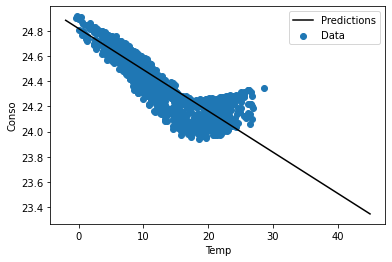

In [172]:
plot_temp(x, y)